In [1]:
import pandas as pd 
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

In [2]:
def summarize_data_n(dat):
    dat['device_local_date'] = pd.to_datetime(dat['device_local_date'])
    cols = ['min', 'max', 'Unique visitors', 'Total']
    dat_summ = pd.DataFrame(columns=cols)

    for shopping_center_id, group in dat.groupby('shopping_center_id'):
        first_ent = group['device_local_date'].min()
        last_ent = group['device_local_date'].max()
        unique_visitors = group['device_hash_id'].nunique()
        total = len(group)

        dat_summ.loc[shopping_center_id] = [first_ent, last_ent, unique_visitors, total]

    al = [dat['device_local_date'].min(), dat['device_local_date'].max(),dat['device_hash_id'].nunique(), len(dat)]
    dat_summ.loc['Overall'] = al
    return dat_summ

In [3]:
def samp_counts(data, interval, consolidation=True, interpolation_method='linear'):
    data = data.copy()
    data['device_local_date'] = pd.to_datetime(data['device_local_date'])
    # set index to time series data to apply resampling 
    data.set_index('device_local_date', inplace=True)
    # sampling by minutes --> downsampling (reducing the frequency of the data by aggregating it into larger time intervals)
    # the timestamp data is approximated to the nearest x-minute interval
    df = data.resample(interval).agg({'device_hash_id': 'count'})
    # Interpolation to handle missing intervals 
    if consolidation and interpolation_method != 'none':
        df = df.interpolate(method=interpolation_method)
    return df

In [4]:
def plot_f(data, interval):
    malls = data['shopping_center_id'].unique()
    for m in malls:
        d1 = data.loc[data['shopping_center_id'] == m]
        test = samp_counts(d1, interval)
        test.columns = ['occurrences']
        # Apply ADF test to check stationary
        result = adfuller(test['occurrences'])
        test_statistic = result[0]
        p_value = result[1]
        print(test_statistic)
        is_stationary = p_value < 0.05
        print(is_stationary)
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(test.index, test['occurrences'])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))  
        ax.xaxis.set_major_locator(mdates.DayLocator())  
        ax.set_xlabel('Time')
        ax.set_ylabel('Occurrences')
        ax.set_title('Mall ID: {} - September'.format(m))
        plt.show()

In [5]:
def not_busy_periods(df, threshold_percentile, noise_filter=None):
    # Create new columns for time and day
    df['time'] = df['device_local_date'].dt.time
    df['day'] = df['device_local_date'].dt.weekday

    # Calculate occurrences for each time and day
    new_df = df.groupby(['day', 'time'], as_index=False).agg({'occurrences': 'sum'})

    # Calculate threshold value as the given percentile of occurrences greater than 0 for each day
    dat = new_df[new_df['occurrences'] > 0]
    dat = dat.groupby(['day'], as_index=False).agg({'occurrences': lambda x: np.percentile(x, q=threshold_percentile)})
    dat.columns = ['day_id', 'threshold_value']

    # Join and determine not busy periods (occurrence < threshold value)
    not_busy_periods_df = new_df.set_index('day').join(dat.set_index('day_id'), how='left').reset_index()
    not_busy_periods_df['not_busy'] = np.where(not_busy_periods_df['occurrences'] < not_busy_periods_df['threshold_value'], 1, 0)

    # desired dataframe
    days = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    not_busy_periods_df['day_name'] = not_busy_periods_df['index'].apply(lambda x: days[x])
    not_busy_periods_df = not_busy_periods_df.drop(columns=['occurrences', 'threshold_value', 'index'])
    not_busy_periods_df = not_busy_periods_df[['day_name', 'time', 'not_busy']]

    # Apply noise filter if specified
    if noise_filter:
        window_size, min_occurrences = noise_filter
        if window_size >= min_occurrences:
            not_busy_periods_df['rolling_not_busy'] = np.where(
                not_busy_periods_df['not_busy'].rolling(window_size, min_periods=1, center=True).sum() > min_occurrences,
                1,
                0
            )
            not_busy_periods_df['not_busy'] = not_busy_periods_df[['not_busy', 'rolling_not_busy']].max(axis=1)
            not_busy_periods_df = not_busy_periods_df.drop(columns=['rolling_not_busy'])
        else:
            raise NameError("Inconsistent filter")

    # Calculate the percentage of not busy periods
    percentage_not_busy = len(not_busy_periods_df[not_busy_periods_df['not_busy'] == 1]) / len(new_df)

    return not_busy_periods_df, percentage_not_busy

In [6]:
def offpeak_periods_full(df, threshold, interval, noise_filter=None):
    malls_id = dat['shopping_center_id'].unique()
    final_dat = pd.DataFrame()
    for m in malls_id:
        dat_selec = dat[dat.shopping_center_id == m]
        test = samp_counts(dat_selec, interval).reset_index()
        test.columns = ['device_local_date', 'occurrences']
        [a,b] =  not_busy_periods(test, threshold)
        a['shopping_center_id'] = m
        final_dat = pd.concat([final_dat, a])
    return final_dat

In [7]:
def analysis_by_device(data,interval,time_gap):
    data['device_local_date'] = pd.to_datetime(data['device_local_date'])
    # sort to have consecutive rows ( same hash ids will be after each other)
    new_df = data.sort_values(['device_hash_id', 'shopping_center_id', 'device_local_date']).reset_index()
    # use diff method to calculate time different between 2 consecutive rows 
    new_df['visit_diff'] = new_df['device_local_date'].diff().fillna(pd.Timedelta(seconds=0))
    # check if same device between all rows False --> device not changed, True --> device changed 
    new_df['device_diff'] = new_df['device_hash_id'].ne(new_df['device_hash_id'].shift(1))
    # set True when there is diff between days not time 
    new_df['day_diff'] = (new_df['device_local_date'].dt.day != new_df['device_local_date'].dt.day.shift(1))
    # if visit diff exceeds a certain gap_visit, set to True
    new_df['thersh_diff'] = new_df['visit_diff'] >= time_gap
    # if one of the 3 column is True then their is an event break, eirther we are comparing diff devices 
    # or entrace on different days 
    # or entrace on different times but here time exceeds 1 hr between both entrance
    new_df['visit_break'] = np.where(new_df['device_diff'] | new_df['day_diff'] | new_df['thersh_diff'], 1, 0) 
    new_df = new_df.drop(columns = ['index', 'device_diff', 'day_diff', 'thersh_diff'])    
    new_df.loc[new_df.visit_break == 1, 'visit_diff'] = pd.Timedelta(seconds=0)
    # approximation of time rounded to lower multiple of 10 Min
    new_df['time_approx'] = new_df['device_local_date'].dt.floor(str(interval) + 'min').dt.time
    new_df['day'] = new_df['device_local_date'].dt.weekday
    days = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
    new_df['day_name'] = new_df.day.apply(lambda x: days[x])  
    return new_df

In [8]:
def joined_dataframes_stat(df, new_df):
    final_df = new_df.merge(df, how='left', left_on=['shopping_center_id', 'day_name', 'time_approx'], right_on=['shopping_center_id', 'day_name', 'time'])
    final_df = final_df.drop(columns = ['time_approx', 'day', 'day_name', 'time'])
    final_df = final_df.groupby('device_hash_id', as_index=False).agg({'visit_diff': 'sum', 'visit_break': 'sum', 'not_busy': 'sum'})
    # convert the time difference from a timedelta format to a numerical value representing the duration in hours.
    final_df['visit_diff'] /= pd.Timedelta(hours=1)
    return final_df

In [9]:
def clustering_filter(data, stat):
    d_class = pd.DataFrame()
    shops_prop_employees = []
    for s in list(data['shopping_center_id'].unique()):
        devices = data[data.shopping_center_id == s].device_hash_id.unique()
        get_stats = stat[stat.device_hash_id.isin(devices)]
        # Initialize DBSCAN model with  parameters
        fit_data = get_stats.iloc[:, 1:].to_numpy()
        dbscan = DBSCAN(eps=1.5, min_samples=30)
        model = dbscan.fit(fit_data)
        # results
        ## assigns True to non outliers and false otherwise 
        d = devices.copy()
        st = get_stats.copy()
        st['results_DBSCAN'] = model.labels_ == 0
        st['shopping_center_id'] = s
        d_class = pd.concat([d_class, st[['shopping_center_id', 'device_hash_id', 'results_DBSCAN']]])
        # proportion of employees
        prop_employees = len(st[st['results_DBSCAN'] == False]) / len(st)  
        shops_prop_employees.append([s, prop_employees])
    shops_prop_employees = pd.DataFrame(data=shops_prop_employees, columns=['shopping_center_id', 'prop_employees'])
    d_class = d_class.reset_index().drop(columns=['index'])
    return d_class, shops_prop_employees

In [10]:
def reshape_data(dat):
    dat['time'] = dat['device_local_date'].dt.time 
    dat['day_id'] = dat['device_local_date'].dt.weekday
    dat['afternoon'] = dat['device_local_date'].dt.hour >= 12 
    dat = dat.groupby(['day_id', 'time', 'afternoon'], as_index = False).agg({'occurrences': 'sum'})  
    return dat
def get_weekly_data(dat):
    week_stat = dat.copy()
    week_stat = week_stat.groupby('day_id', as_index = False).agg({'occurrences': 'sum'})
    week_stat.columns = ['day_id', 'daily_occurrences']
    weekly_mean_attendance = np.mean(week_stat['daily_occurrences'])
    return week_stat, weekly_mean_attendance
def criteria_1(dat):
    df_min_occ = dat.copy()
    df_min_occ = df_min_occ[df_min_occ['occurrences'] > 0]
    # for each day monday --> 0 --> calculate qth percentile and any time interval
    # with occurence less than this number is considered closed 
    df_min_occ = df_min_occ.groupby(['day_id'], as_index = False).agg({'occurrences': lambda x: np.percentile(x, q=15)})
    df_min_occ.columns = ['day_id', 'threshold']
    return df_min_occ
def criteria_2(dat):
   # criteria 2
    mall_counts = dat.copy()
    mall_counts['rolling_is_closed'] = np.where(mall_counts['is_closed'].rolling(6, min_periods=1, center=True).sum() > 4, 1, 0)
    mall_counts['is_closed'] = mall_counts['rolling_is_closed'] + mall_counts['is_closed']
    mall_counts.columns = ['weekday_id', 'time', 'afternoon', 'occurrences', 'threshold', 'is_closed', 'rolling_is_closed']
    return mall_counts
def apply_midday_criteria(dat, apply_m = True):
    mall_counts = dat.copy()
    if apply_m:
        # take min and max open period for each period
        mall_counts = mall_counts.groupby(['weekday_id', 'weekday', 'afternoon'], as_index = False).agg({'time': ['min', 'max']})
        mall_counts['afternoon'] = np.where(mall_counts['afternoon'], 'Afternoon', 'Morning')
        mall_counts.columns = ['weekday_id', 'Weekday', 'Period', 'Opening', 'Closing']
    else:
        mall_counts = mall_counts.groupby(['weekday_id', 'weekday'], as_index = False).agg({'time': ['min', 'max']})
        mall_counts.columns = ['weekday_id', 'Weekday', 'Opening', 'Closing']
    return mall_counts

In [11]:
def determine_opening_hours(dat,resulted_dat,interval):
    results = pd.DataFrame()
    # combine original and clustering dataframe result 
    merged = dat.merge(resulted_dat, how = 'left', left_on = ['shopping_center_id', 'device_hash_id'], right_on=['shopping_center_id', 'device_hash_id'])
    # considering customers
    merged = merged.loc[merged['results_DBSCAN'] == True]
    merged = merged.reset_index().drop(columns = ['results_DBSCAN', 'index'])  
    for s in merged['shopping_center_id'].unique():
        mall = merged.loc[merged['shopping_center_id'] ==  s]
        mall_counts = samp_counts(mall, interval)
        mall_counts = mall_counts.reset_index()        
        mall_counts.columns = ['device_local_date', 'occurrences']
        # apply previous defined functions 
        mall_counts = reshape_data(mall_counts)
        [week_stat, weekly_mean_attendance] = get_weekly_data(mall_counts)
        df_min_occ = criteria_1(mall_counts)
        # join with occurences per mall dataframe 
        mall_counts = mall_counts.set_index('day_id').join(df_min_occ.set_index('day_id'), how='left').reset_index()
        # consider closed when occ < criteria (criteria 1)
        mall_counts['is_closed'] = np.where(mall_counts['occurrences'] < mall_counts['threshold'], 1, 0)
        # criteria 2
        mall_counts = criteria_2(mall_counts)
        # criteria 3 
        week_stat['is_closed_full_day'] = np.where(week_stat['daily_occurrences']*5 < np.mean(week_stat['daily_occurrences']), 1, 0)
        
        # join with mall counts dataframe 
        mall_counts = mall_counts.set_index('weekday_id').join(week_stat.set_index('day_id'), how='left').reset_index()
        mall_counts['is_closed'] = mall_counts['is_closed'] + mall_counts['is_closed_full_day']
        mall_counts.columns = ['weekday_id' if x=='index' else x for x in mall_counts.columns]
        
        # consider time interval which are not classified as closed
        mall_counts = mall_counts[mall_counts['is_closed'] == 0]
        days = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
        mall_counts['weekday'] = mall_counts.weekday_id.apply(lambda x: days[x]) 
        mall_counts = apply_midday_criteria(mall_counts,False)
        
        # final returned dataframe 
        mall_counts = mall_counts.sort_values('weekday_id')
        mall_counts = mall_counts.drop(columns = ['weekday_id'])
        mall_counts['shopping_center_id'] = s
        results = pd.concat([results, mall_counts])
    return results

In [12]:
def apply_algo(data):
    data['device_local_date'] = pd.to_datetime(dat['device_local_date'])
    data_not_busy = offpeak_periods_full(data, 25, '10Min')
    test = analysis_by_device(data, 10, pd.Timedelta(hours=1))
    test = joined_dataframes_stat(data_not_busy, test)
    (a,b) = clustering_filter(dat, test)
    final_data = determine_opening_hours(dat, a, '10Min')
    return final_data

In [13]:
dat = pd.read_csv('at_home_test_data_study_centers_201909 - study_centers_201909.csv')

## Currently we have device_hash_id of people who entered the mall, but specifically we dont know if they are customers or employees. Identifying that is important to determine the opening hours of a mall.

### To do so, we need to focus on time intervals during which there is relatively low activity or fewer occurrences compared to other time intervals. 

### Steps followed to determine opening hours of each mall: 
###### 1. Get Some Statistics about the data (for each mall, the unique and total number of visitors + earliest and latest entrances)
###### 2.  Calculate the sample counts for each combination of shopping center, device, and day which provides information on the frequency of visits for different devices in different shopping centers on different days. (Downsampling was used) 
###### 3. Determine in general for a specific day and time if it is a busy period or not (alot of people entering at that time ), this will help differentiate employees from custromers. 
###### 4. Analysis by device : to undesrtand the footfall and overall presence of visiors in each mall, we will focus now on device levels analysis. 
###### 5. use a clustering technique density-based clustering: DBSCAN which is a density-based clustering algorithm that identifies clusters based on the density of data points. This makes it suitable for capturing the dense regions of poeple's activity within the mall. to determin emplyess from others.

In [14]:
dat['device_local_date'] = pd.to_datetime(dat['device_local_date'])

## 1&2. Exploratory Data Analysis 

In [15]:
summarize_data_n(dat)

min                 max  \
0cd35523-1eca-4f09-ab0d-0b506ae9d986 2019-09-01 16:18:00 2019-09-17 21:03:30   
599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-01 00:19:53 2019-09-17 23:59:59   
b43e9e4f-acd1-4941-874d-e0c5650ab91e 2019-09-01 05:10:31 2019-09-17 22:07:39   
cb2d5bb6-c372-4a51-8231-4ffa288a0c28 2019-09-01 00:26:16 2019-09-17 21:38:03   
Overall                              2019-09-01 00:19:53 2019-09-17 23:59:59   

                                     Unique visitors  Total  
0cd35523-1eca-4f09-ab0d-0b506ae9d986            1077  11292  
599cb959-11ef-49aa-9eb3-e6c17b4ea6ba            2417  39827  
b43e9e4f-acd1-4941-874d-e0c5650ab91e            1024  15080  
cb2d5bb6-c372-4a51-8231-4ffa288a0c28            1334  15639  
Overall                                         5702  81838

#### example of results of samp_counts function 

In [16]:
s = "599cb959-11ef-49aa-9eb3-e6c17b4ea6ba"  
x_thresh = 25   
interval = '10Min'
dat_selec = dat[dat.shopping_center_id == s]
test = samp_counts(dat_selec, interval).reset_index()
test.columns = ['device_local_date', 'occurrences']
test

device_local_date  occurrences
0    2019-09-01 00:10:00            1
1    2019-09-01 00:20:00            0
2    2019-09-01 00:30:00            0
3    2019-09-01 00:40:00            0
4    2019-09-01 00:50:00            0
...                  ...          ...
2442 2019-09-17 23:10:00            0
2443 2019-09-17 23:20:00            0
2444 2019-09-17 23:30:00            0
2445 2019-09-17 23:40:00            0
2446 2019-09-17 23:50:00            1

[2447 rows x 2 columns]

-6.107908344932106
True


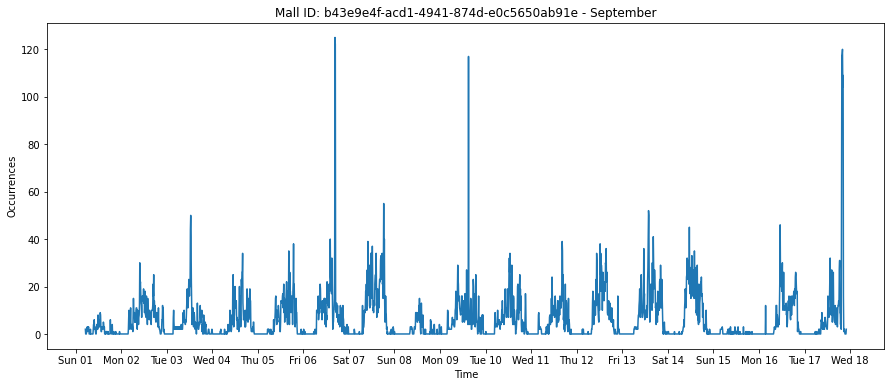

-6.451985722984802
True


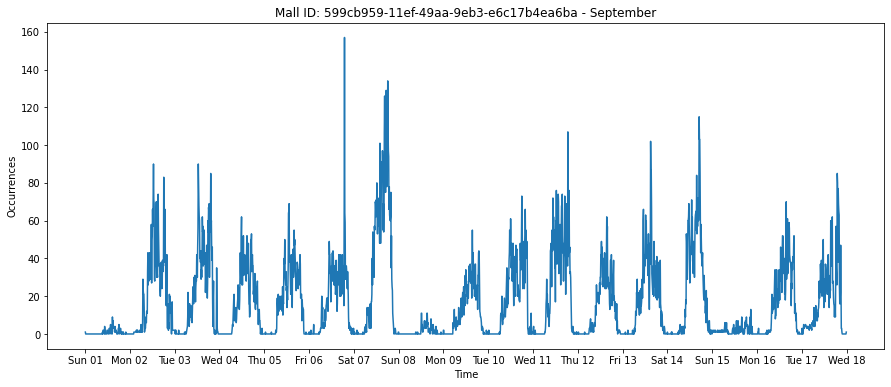

-7.11230118961191
True


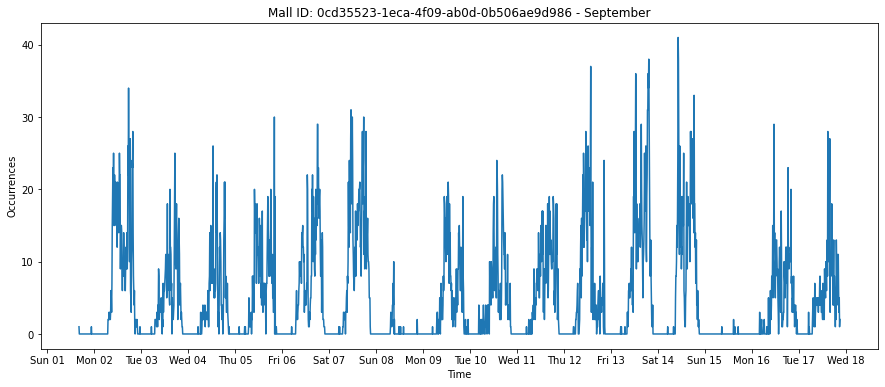

-7.004660522730768
True


In [17]:
plot_f(dat, '10Min')

## 3. Not Busy Periods 

In [18]:
data_not_busy = offpeak_periods_full(dat, 25, '10Min')

In [19]:
data_not_busy.head(5)

day_name      time  not_busy                    shopping_center_id
0      Mon  00:00:00         1  b43e9e4f-acd1-4941-874d-e0c5650ab91e
1      Mon  00:10:00         1  b43e9e4f-acd1-4941-874d-e0c5650ab91e
2      Mon  00:20:00         1  b43e9e4f-acd1-4941-874d-e0c5650ab91e
3      Mon  00:30:00         1  b43e9e4f-acd1-4941-874d-e0c5650ab91e
4      Mon  00:40:00         1  b43e9e4f-acd1-4941-874d-e0c5650ab91e

## 4. Device level Analysis 

In [20]:
test = analysis_by_device(dat, 10, pd.Timedelta(hours=1))

In [21]:
test

shopping_center_id   device_local_date  \
0      599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-13 19:34:27   
1      599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-06 17:26:45   
2      599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-06 17:29:37   
3      599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-06 17:31:47   
4      599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-06 18:17:50   
...                                     ...                 ...   
81833  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-14 18:40:22   
81834  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-14 18:47:36   
81835  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-14 18:50:03   
81836  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-14 19:00:19   
81837  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba 2019-09-14 19:10:46   

      device_hash_id      visit_diff  visit_break time_approx  day day_name  
0           0.00E+00 0 days 00:00:00            1    19:30:00    4      Fri  
1         000a7a5fe9 0 days 00:00:00            1    17:20:00    4      Fri  
2         000a7a5fe9 0 days 00:02:52            0    17:20:00    4      Fri  
3         000a7a5fe9 0 days 00:02:10            0    17:30:00    4      Fri  
4         000a7a5fe9 0 days 00:46:03            0    18:10:00    4      Fri  
...              ...             ...          ...         ...  ...      ...  
81833     fff2d6eaa9 0 days 00:30:59            0    18:40:00    5      Sat  
81834     fff2d6eaa9 0 days 00:07:14            0    18:40:00    5      Sat  
81835     fff2d6eaa9 0 days 00:02:27            0    18:50:00    5      Sat  
81836     fff2d6eaa9 0 days 00:10:16            0    19:00:00    5      Sat  
81837     fff2d6eaa9 0 days 00:10:27            0    19:10:00    5      Sat  

[81838 rows x 8 columns]

In [22]:
test = joined_dataframes_stat(data_not_busy, test)

In [23]:
test

device_hash_id  visit_diff  visit_break  not_busy
0          0.00E+00    0.000000            1         0
1        000a7a5fe9    1.313889            2         0
2        000d783b1a    0.000000            1         0
3        0016ad7e8f    7.924167            1         5
4        0017e9f968    0.000000            1         0
...             ...         ...          ...       ...
5697     ffda868f7e    2.003056            1         0
5698     ffdccbb668    2.432778            1         0
5699     ffe0f766cb    1.386111            2         0
5700     ffe5628a16    1.216944            1         0
5701     fff2d6eaa9    3.728611            3         0

[5702 rows x 4 columns]

## 5. Clustering 


 - to identify similar groups of devices based on the previous criteria, clustering devices, patterns and similarities can be identified without imposing preconceived notions. This approach can help us reveal hidden patterns and groupings in the data.

In [24]:
(a,b) = clustering_filter(dat, test)

In [25]:
a

shopping_center_id device_hash_id  results_DBSCAN
0     b43e9e4f-acd1-4941-874d-e0c5650ab91e     0016ad7e8f           False
1     b43e9e4f-acd1-4941-874d-e0c5650ab91e     00c8b72678            True
2     b43e9e4f-acd1-4941-874d-e0c5650ab91e     0155c8d4a8            True
3     b43e9e4f-acd1-4941-874d-e0c5650ab91e     0169e9bd3a            True
4     b43e9e4f-acd1-4941-874d-e0c5650ab91e     01dbbae174            True
...                                    ...            ...             ...
5847  cb2d5bb6-c372-4a51-8231-4ffa288a0c28     fedecbb92e            True
5848  cb2d5bb6-c372-4a51-8231-4ffa288a0c28     fee68a8948            True
5849  cb2d5bb6-c372-4a51-8231-4ffa288a0c28     fef55f6b7b            True
5850  cb2d5bb6-c372-4a51-8231-4ffa288a0c28     ff22d4ee02            True
5851  cb2d5bb6-c372-4a51-8231-4ffa288a0c28     ffa7c0ca26            True

[5852 rows x 3 columns]

In [26]:
b

shopping_center_id  prop_employees
0  b43e9e4f-acd1-4941-874d-e0c5650ab91e        0.063477
1  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba        0.047580
2  0cd35523-1eca-4f09-ab0d-0b506ae9d986        0.043640
3  cb2d5bb6-c372-4a51-8231-4ffa288a0c28        0.044228

## Opening Hours 
- In order to determine if a shopping center is closed during specific time intervals, 3 criterias are considered: 
1. Calculate the minimum attendance threshold for each day of the week. This threshold is determined by finding the desired percentile (specified by min_attendance_perc, typically set to 15%) of the attendance distribution.
__If the attendance for a specific time interval falls below this threshold, that interval is considered closed.__

2. It involves analyzing a rolling window of 6 consecutive periods centered around each time interval. If more than two-thirds of the periods within the window are classified as closed based on the first filter, the center is considered closed for that specific time interval. Otherwise, it is considered open.
__This helps identify continuous periods of closure within the dataset__

3. It aims to identify days with significantly low attendance compared to the rest of the week. It calculates the daily occurrences multiplied by five and compares it to the weekly mean attendance. If the result is less than the weekly mean attendance, it considers that period as closed.

4. Finally, By performing steps 1,2,3; we are effectively removing the closed time intervals from our data, focusing only on the time intervals that are considered open.

In [27]:
determine_opening_hours(dat, a,'10Min')

Weekday   Opening   Closing                    shopping_center_id
0     Mon  08:00:00  20:20:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
1     Tue  08:30:00  21:10:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
2     Wed  08:20:00  20:20:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
3     Thu  08:20:00  20:20:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
4     Fri  08:30:00  21:00:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
5     Sat  07:50:00  19:50:00  b43e9e4f-acd1-4941-874d-e0c5650ab91e
0     Mon  07:40:00  21:50:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
1     Tue  07:20:00  20:50:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
2     Wed  07:00:00  20:50:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
3     Thu  08:30:00  21:10:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
4     Fri  09:10:00  21:10:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
5     Sat  08:10:00  22:30:00  599cb959-11ef-49aa-9eb3-e6c17b4ea6ba
0     Mon  09:10:00  20:30:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
1     Tue  10:30:00  20:30:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
2     Wed  09:30:00  20:20:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
3     Thu  09:10:00  20:00:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
4     Fri  10:00:00  20:40:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
5     Sat  09:30:00  20:20:00  0cd35523-1eca-4f09-ab0d-0b506ae9d986
0     Mon  08:50:00  20:50:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
1     Tue  07:20:00  21:20:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
2     Wed  08:50:00  20:50:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
3     Thu  09:00:00  20:10:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
4     Fri  09:30:00  22:50:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
5     Sat  08:40:00  20:50:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28
6     Sun  09:10:00  21:40:00  cb2d5bb6-c372-4a51-8231-4ffa288a0c28

In [28]:
datas = apply_algo(dat)